# Setting everything up

In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.special import eval_legendre
from scipy.linalg import svd, norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

In [2]:
# just generates Gaussian data scaled to [-1,1]
def generate_scaled_data(N, d, seed=42):
    np.random.seed(seed)
    
    # Step 1: Sample from multivariate normal
    Z = np.random.randn(N, d)  # standard normal
    
    # Step 2: Scale each coordinate to [-1, 1]
    Z_min = Z.min(axis=0)
    Z_max = Z.max(axis=0)
    Z_scaled = 2 * (Z - Z_min) / (Z_max - Z_min) - 1  # linear transform to [-1, 1]
    
    return Z_scaled

In [3]:
def generate_gaussian(N, mean, std, seed=None):
    """
    Generate N points from a Gaussian with specified means and std deviations
    Eliminates points outside of [-1,1] to ensure the Legendre basis works well
    
    Returns:
        array of shape (N,) with Gaussian distribution
    """
    if seed is not None:
        np.random.seed(seed)
        
    vals = []
    while len(vals) < N:
        x = np.random.normal(loc=mean, scale=std, size=N)
        mask = (x >= -1) & (x <= 1)
        vals.extend(x[mask])
        
    return np.array(vals[:N])

In [4]:
def d_dim_gaussian_density(means, stds, grid_size=100, i=0, j=1):
    """
    Generates the density of a d-dimensional axis-aligned Gaussian,
    and returns a 2D slice over dimensions i and j for visualization.

    Args:
        means (list): List of length d of means.
        stds (list): List of length d of std deviations.
        grid_size (int): Resolution of the grid.
        i (int): Index of the first coordinate to slice.
        j (int): Index of the second coordinate to slice.

    Returns:
        X, Y: Meshgrid arrays for the i and j coordinates.
        density_slice: 2D array of shape (grid_size, grid_size) with the sliced density.
    """
    d = len(means)
    assert len(stds) == d
    assert 0 <= i < d and 0 <= j < d and i != j

    # Grid over [-1, 1]^d
    x = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, x)

    # Create meshgrid for all d dimensions, filled with zeros
    all_coords = np.zeros((grid_size, grid_size, d))

    # Set the i-th and j-th coordinates to vary over the grid
    all_coords[:, :, i] = X
    all_coords[:, :, j] = Y

    # Compute the density
    density = np.ones((grid_size, grid_size))
    for k in range(d):
        mu = means[k]
        sigma = stds[k]
        xk = all_coords[:, :, k]
        density *= (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((xk - mu) / sigma) ** 2)

    return X, Y, density

In [5]:
def legendre_vals_1d(z, degree):
    """
    Evaluate the first (degree+1) normalized Legendre polynomials at points z ∈ [−1,1].
    Returns an (N, degree+1) array (note these are "features").
    """
    N = z.shape[0]
    P = np.empty((N, degree+1))
    # normalization sqrt((2k+1)/2) makes the polynomials orthonormal on [-1,1]
    for k in range(degree+1):
        Pk = eval_legendre(k, z)
        P[:, k] = np.sqrt((2*k+1)/2) * Pk
    return P

In [6]:
# Monte Carlo integrator for L2‐error
def relative_L2_error(f_est, f_true, sample_points, domain_vol):
    """
    f_est, f_true: callables taking array (M,d) → (M,)
    sample_points: array (M,d) drawn uniformly from domain
    domain_vol: volume of the domain
    """
    M = sample_points.shape[0]
    est_vals  = f_est(sample_points)
    est_vals[est_vals < 0] = 0
    true_vals = f_true(sample_points)
    sq_diff = (est_vals - true_vals)**2
    sq_true = true_vals**2
    # integral ≈ domain_vol * average
    int_diff = domain_vol * np.mean(sq_diff)
    int_true = domain_vol * np.mean(sq_true)
    return np.sqrt(int_diff / int_true)

# Algorithm 1 BAD (too much memory)

In [7]:
# building this is the memory bottleneck
# Builds matrix with N*m^(d-1) entries
# I think this is just inherent to the problem

def build_Sj_bad(features, j):
    """
    Given a list `features` of length d, where features[k] is (N, m_k),
    build the tensor-product feature matrix S_j for coordinate j:
    shape (N, ∏_{k≠j} m_k).
    """
    N = features[0].shape[0]
    # Start with a (N,1) column of ones
    S = np.ones((N, 1))
    for k, Fk in enumerate(features):
        if k == j:
            continue
        # S: (N, a), Fk: (N, b)
        # We want (N, a*b) where each (i, (p,q)) = S[i,p] * Fk[i,q]
        S = (S[:, :, None] * Fk[:, None, :]).reshape(N, -1)
    return S

In [8]:
def algorithm_1_bad(data, r, m_list):
    """
    Generalized Algorithm 1 sketch for d-dimensional data.
    
    Inputs:
      - data:   array of shape (N, d) with each coord in [-1,1]
      - r:      target rank (must be <= min(m_j, ∏_{k≠j} m_k) for all j)
      - m_list: list of ints [m_0, m_1, ..., m_{d-1}], # of Legendre modes per coord
    
    Returns:
      - U_list: list of length d; U_list[j] is (m_j, r) matrix of top-left singular vecs
      - S_list: list of length d; S_list[j] is (r,) vector of singular values
      - V_list: list of length d; V_list[j] is (∏_{k≠j}m_k, r) matrix of top-right singular vecs
    """
    N, d = data.shape

    # Guarantees that whether we pass an r list or just r as an int it'll work
    if isinstance(r, int):
        r_list = [r]*d
    else:
        r_list = r
    
    # 0) Setting everything up to use the algorithm described in my notes
    features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(d)]
    
    U_list, S_list, V_list = [], [], []
    
    # 1) Actually performing the algorithm
    for j in range(d):
        Mj = features[j]               # (N, m_j)
        Sj = build_Sj_bad(features, j)     # (N, L_j = ∏_{k≠j} m_k)
        
        if r_list[j] > min(Mj.shape[1], Sj.shape[1]):
            raise ValueError(f"r={r} too large for coordinate {j}: "
                             f"max rank = {min(Mj.shape[1], Sj.shape[1])}")
        
        # sketch moments: C_j[mu,eta] = (1/N) ∑_i Mj[i,mu] * Sj[i,eta], (15)
        Cj = (Mj.T @ Sj) / N          # shape (m_j, L_j)
        
        # truncated SVD, I discuss in my notes why performing the SVD on C is correct
        U, s, Vt = svd(Cj, full_matrices=False)
        U_list.append(U[:, :r_list[j]])       # (m_j, r)
        S_list.append(s[:r_list[j]])          # (r,)
        V_list.append(Vt[:r_list[j], :].T)    # (L_j, r)
    
    return U_list, S_list, V_list

## Sanity checks

In [9]:
N = 5000
x = np.random.uniform(-1,1, size=N)
y = np.random.uniform(-1,1, size=N)
data = np.vstack([x,y]).T       # shape (N,2)

# Run Algorithm 1 sketch with target rank r=2, using m=5 modes per coord
U_list, S_list, V_list = algorithm_1_bad(data, r=3, m_list=[5,5])

# Inspect singular values for each coordinate
for j, s in enumerate(S_list):
    print(f"Coordinate {j}: singular values = {s}")

Coordinate 0: singular values = [0.50025954 0.02097594 0.01842509]
Coordinate 1: singular values = [0.50025954 0.02097594 0.01842509]


In [10]:
N = 10000
x = generate_gaussian(N, 0.2, .1, seed=0)
y = generate_gaussian(N, -0.1, 1, seed=1)
data = np.vstack([x, y]).T

# Run sketch
r = 3
m_list = [5, 5]
U_list, S_list, V_list = algorithm_1_bad(data, r, m_list)

# Compute metrics
drop_ratios = []
alignments = []
for j in range(2):
    s = S_list[j]
    ratio = s[0] / (s[1] if len(s) > 1 and s[1] > 0 else np.nan)
    drop_ratios.append(ratio)
    # alignment with e0
    alignment = abs(U_list[j][0, 0])
    alignments.append(alignment)

results = pd.DataFrame({
    "Coordinate": [0, 1],
    "Singular Value": [S_list[0][0], S_list[1][0]],
    "Drop Ratio (1st/2nd)": drop_ratios,
    "Alignment with v₀": alignments
})

In [11]:
# the second coordinate should be much better aligned with v0 because v0 is a straight line (0th Legendre polynomial)
# and the second coordinate is a much wider Gaussian (closer to being a straight line)

results

,Coordinate,Singular Value,Drop Ratio (1st/2nd),Alignment with v₀
0,0,0.862566,108.707399,0.586598
1,1,0.862566,108.707399,0.988235


In [12]:
# 2) Check reconstruction error of C ≈ U S V^T
# Reconstruct C for j=0 (example)
features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(2)]
V0 = features[0]
S0 = build_Sj_bad(features, 0)
C0 = (V0.T @ S0) / N
U0, s0, Vt0 = svd(C0, full_matrices=False)
# approximate C0
approxC0 = U0[:, :r] @ np.diag(s0[:r]) @ Vt0[:r, :]
recon_error = norm(C0 - approxC0, 'fro') / norm(C0, 'fro')

# 3) Stability under subsampling: split data
data_A = data[:N//2]
data_B = data[N//2:]
U_A, S_A, V_A = algorithm_1_bad(data_A, r, m_list)
U_B, S_B, V_B = algorithm_1_bad(data_B, r, m_list)

# Compute principal angle between U_A[j] and U_B[j] for each j
stability = []
for j in range(2):
    # since r=1, principal angle cos = |u_A^T u_B|
    cos_angle = abs((U_A[j][:, 0].T @ U_B[j][:, 0]))
    stability.append(cos_angle)

# 4) Compile results
results = pd.DataFrame({
    "Check": ["Reconstruction Error", "Stability Coord 0", "Stability Coord 1"],
    "Value": [recon_error, stability[0], stability[1]]
})

results

,Check,Value
0,Reconstruction Error,0.000106
1,Stability Coord 0,0.999998
2,Stability Coord 1,0.999875


# Algorithm 1 safe

In [13]:
def Cj_without_Sj(features, j):
    """
    Compute Cj = (1/N) * Mj^T @ Sj without ever forming the full Sj matrix.
    - features: list of length d, where features[k] has shape (N, m_k)
    - j: the coordinate index in [0..d-1]
    Returns: Cj of shape (m_j, L_j), where L_j = ∏_{k≠j} m_k.
    """
    N = features[0].shape[0]
    Mj = features[j]                     # (N, m_j)
    m_j = Mj.shape[1]

    # Compute L_j = product of all m_k for k ≠ j:
    L_j = 1
    for k, Fk in enumerate(features):
        if k == j:
            continue
        L_j *= Fk.shape[1]

    # Allocate Cj as zeros
    Cj = np.zeros((m_j, L_j), dtype=float)

    # Now accumulate row‐by‐row:
    # For each data‐point i, build the 1×L_j row s_i = kron_{k≠j}( features[k][i, :] ).
    # Then add Mj[i,:] outer‐product with s_i to Cj.  Finally divide by N.
    for i in range(N):
        # start s_i as a length‐1 array [1.0]
        s_i = np.array([1.0], dtype=float)

        # for each k ≠ j, do a Kron step to expand s_i
        for k, Fk in enumerate(features):
            if k == j:
                continue
            # Fk[i,:] has shape (m_k,)
            # s_i has shape (current_length,)
            # their kronecker now has shape (current_length * m_k,)
            s_i = np.kron(s_i, Fk[i, :])

        # s_i is now exactly what row i of S_j would have been (shape (L_j,))
        # accumulate: Cj += Mj[i,:]^T   ×   s_i
        #   (Mj[i,:] has length m_j; s_i has length L_j)
        #
        # This does:  Cj[p, q] += Mj[i, p] * s_i[q]
        Cj += np.outer(Mj[i, :], s_i)

    # Finally scale by 1/N
    Cj /= float(N)
    return Cj

In [14]:
def algorithm_1(data, r, m_list):
    """
    Generalized Algorithm 1 sketch for d-dimensional data.
    
    Inputs:
      - data:   array of shape (N, d) with each coord in [-1,1]
      - r:      target rank (must be <= min(m_j, ∏_{k≠j} m_k) for all j)
      - m_list: list of ints [m_0, m_1, ..., m_{d-1}], # of Legendre modes per coord
    
    Returns:
      - U_list: list of length d; U_list[j] is (m_j, r) matrix of top-left singular vecs
      - S_list: list of length d; S_list[j] is (r,) vector of singular values
      - V_list: list of length d; V_list[j] is (∏_{k≠j}m_k, r) matrix of top-right singular vecs
    """
    N, d = data.shape

    # Guarantees that whether we pass an r list or just r as an int it'll work
    if isinstance(r, int):
        r_list = [r]*d
    else:
        r_list = r
    
    # 0) Setting everything up to use the algorithm described in my notes
    features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(d)]
    
    U_list, S_list, V_list = [], [], []
    
    # 1) Actually performing the algorithm
    for j in range(d):
        # sketch moments: C_j[mu,eta] = (1/N) ∑_i Mj[i,mu] * Sj[i,eta], (15)
        Cj = Cj_without_Sj(features, j)          # shape (m_j, L_j)

        if r_list[j] > min(Cj.shape):
            raise ValueError(f"r={r} too large for coordinate {j}: "
                             f"max rank = {min(Cj.shape)}")
        
        # truncated SVD, I discuss in my notes why performing the SVD on C is correct
        U, s, Vt = svd(Cj, full_matrices=False)
        U_list.append(U[:, :r_list[j]])       # (m_j, r)
        S_list.append(s[:r_list[j]])          # (r,)
        V_list.append(Vt[:r_list[j], :].T)    # (L_j, r)
    
    return U_list, S_list, V_list

## Sanity check

In [15]:
N = 5000
x = np.random.uniform(-1,1, size=N)
y = np.random.uniform(-1,1, size=N)
data = np.vstack([x,y]).T       # shape (N,2)

# Run Algorithm 1 sketch with target rank r=2, using m=5 modes per coord
U_list, S_list, V_list = algorithm_1(data, r=3, m_list=[5,5])

# Inspect singular values for each coordinate
for j, s in enumerate(S_list):
    print(f"Coordinate {j}: singular values = {s}")

Coordinate 0: singular values = [0.5005529  0.02724392 0.01824369]
Coordinate 1: singular values = [0.5005529  0.02724392 0.01824369]


In [16]:
N = 10000
x = generate_gaussian(N, 0.2, .1, seed=0)
y = generate_gaussian(N, -0.1, 1, seed=1)
data = np.vstack([x, y]).T

# Run sketch
r = 3
m_list = [5, 5]
U_list, S_list, V_list = algorithm_1(data, r, m_list)

# Compute metrics
drop_ratios = []
alignments = []
for j in range(2):
    s = S_list[j]
    ratio = s[0] / (s[1] if len(s) > 1 and s[1] > 0 else np.nan)
    drop_ratios.append(ratio)
    # alignment with e0
    alignment = abs(U_list[j][0, 0])
    alignments.append(alignment)

results = pd.DataFrame({
    "Coordinate": [0, 1],
    "Singular Value": [S_list[0][0], S_list[1][0]],
    "Drop Ratio (1st/2nd)": drop_ratios,
    "Alignment with v₀": alignments
})

In [17]:
# the second coordinate should be much better aligned with v0 because v0 is a straight line (0th Legendre polynomial)
# and the second coordinate is a much wider Gaussian (closer to being a straight line)

results

,Coordinate,Singular Value,Drop Ratio (1st/2nd),Alignment with v₀
0,0,0.862566,108.707399,0.586598
1,1,0.862566,108.707399,0.988235


# Algorithm 3

In [18]:
def ttm(tensor, matrix, mode):
    """
    Mode-n product of `matrix` (shape (J, I_mode))
    with `tensor` (shape (..., I_mode, ...))
    same as tensorly.tenalg.mode_dot(tensor, matrix, mode).
    """
    # 1) tensordot over tensor's axis=mode and matrix's axis=1
    #    result shape = (J, ...) where ... are tensor.shape without mode
    res = np.tensordot(matrix, tensor, axes=[1, mode])
    # 2) we need to move the new axis-0 (the J dimension) into position `mode`
    #    so construct the new axis order
    ndim = tensor.ndim
    # current res axes:    [ new_axis ] + [ all old axes except `mode`, in order ]
    # we want new_axis to go to position `mode`, and shift axes <mode> left by 1
    axes = list(range(1, mode+1)) + [0] + list(range(mode+1, ndim))
    return np.transpose(res, axes)

In [19]:
def compute_coeff_tensor(features):
    """
    Very memory-safe: builds exactly one outer-product at a time.
    Comes from eq 32
    """
    N = features[0].shape[0]
    m_list = [f.shape[1] for f in features]
    C = np.zeros(m_list)

    # zip(*features) walks through i=0..N-1,
    # yielding a tuple (F0[i], F1[i], ..., F{d-1}[i])
    for vecs in zip(*features):
        # start with the first feature-vector
        out = vecs[0]
        # iteratively form the next outer product
        for v in vecs[1:]:
            out = np.multiply.outer(out, v)
        C += out

    return C / N

In [20]:
def algorithm_3(data, r_list, m_list):
    """
    Algorithm 3 in terms of repeated calls to Algorithm 1.
    Returns final coefficient tensor C_e and list of basis functions.
    """
    N, d = data.shape
    
    # we need an even number of data points
    if N%2 == 1:
        N -= 1
        data = data[:-1]
    
    half = N // 2
    
    # split data in half
    A_h, A_hp = data[:half], data[half:]
    
    # Initial subspace estimation via Algorithm 1
    # The equivalence of this with computing the SVD of eq 49 is discussed in my notes
    U_list,_,_ = algorithm_1(A_h, r_list, m_list)
    P_U = [U @ U.T for U in U_list]    # projectors P_{U_j}
    
    # Build per-half feature lists
    feats_h  = [legendre_vals_1d(A_h[:, j],  m_list[j]-1) for j in range(d)]
    feats_hp = [legendre_vals_1d(A_hp[:,j],  m_list[j]-1) for j in range(d)]
    
    # Compute coefficient tensor from first half
    C_h = compute_coeff_tensor(feats_h)  # shape = tuple(m_list)
    
    # Second pass: refine projectors P_{V_j}
    V_list = []
    for j in range(d):
        # partially project C_h along all modes except j
        B_j = C_h.copy()
        for k in range(d):
            if k == j: 
                continue
            B_j = ttm(B_j, P_U[k], mode=k)
    
        # unfold into a matrix for SVD
        shape = B_j.shape
        m_j   = shape[j]
        other = int(np.prod([shape[k] for k in range(d) if k != j]))
        # move mode j to front, then reshape
        B_mat = np.moveaxis(B_j, j, 0).reshape(m_j, other)
    
        # SVD and take top r_j left singular vectors
        U, _, _ = svd(B_mat, full_matrices=False)
        Vj = U[:, :r_list[j]]   # (m_j, r_j)
        V_list.append(Vj)
    
    P_V = [V @ V.T for V in V_list]  # refined projectors
    
    # 5) Final sketch on second half
    C_hp = compute_coeff_tensor(feats_hp)
    C_t  = C_hp.copy()
    for j in range(d):
        C_t = ttm(C_t, P_V[j], mode=j)
    
    # 6) Basis evaluators (for reconstruction)
    basis = [lambda z, deg=m_list[j]-1: legendre_vals_1d(z, deg)
             for j in range(d)]
    
    return C_t, basis

In [21]:
def eval_density(C_e, basis, z):
    """
    Evaluate the reconstructed density at point z.
    """
    # Number of dimensions
    d = C_e.ndim
    assert len(z) == d == len(basis), "Dimension mismatch."

    # Evaluate each mode's basis at the corresponding coordinate
    b_vals = []
    for k in range(d):
        try:
            b = basis[k](z[k])
        except Exception:
            # wrap scalar into array for basis functions expecting array input
            b = basis[k](np.array([z[k]])).ravel()
        b_vals.append(b)

    # Contract C_e against each b_vals[k] in turn:
    val = C_e
    for mode, b in enumerate(b_vals):
        val = np.tensordot(val, b, axes=([0], [0]))

    return float(val)

## Sanity check

In [22]:
# toy data
d = 4
N = 10000
data = np.random.uniform(-1,1,(N,d))
r_list = [3]*d
m_list = [5]*d

C_e, basis = algorithm_3(data, r_list, m_list)

# shouldn't matter at what point we look (uniform density)
z_test = (0.1, -0.5, 0.8, .4)

# would expect to be approx 1/2^d because this the volume, uniform density
print("Estimated density at", z_test, "=", eval_density(C_e, basis, z_test))
print("Expected density: ", 1/2**d)

Estimated density at (0.1, -0.5, 0.8, 0.4) = 0.055835327598779
Expected density:  0.0625


In [23]:
# I don't think this is the memory bottleneck anymore
# is able to run for the m = 3, d = 10, N = 50000, but alg3 struggles here
# I think no matter what, we will always have (m+1)^d entries
# Still very slow thoguh

m = 8
d = 5
N = 5000

np.shape(compute_coeff_tensor([legendre_vals_1d(np.random.uniform(-1,1,N),m) for i in range(d)]))

(9, 9, 9, 9, 9)

# Trying to recreate results

## First a 2D Gaussian

In [165]:
data = np.vstack([generate_gaussian(1000,0.3,0.1),generate_gaussian(1000,-0.4,0.3)]).T

grid_size = 100

x = y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

In [197]:
r_list = [10, 5]      # basis size per dimension
m_list = [15, 10]      # number of projections per dimension

# Run algorithm 3
C_e, basis = algorithm_3(data, r_list, m_list)

In [198]:
density_vrs = np.array([eval_density(C_e, basis, z) for z in grid_points])
density_vrs = density_vrs.reshape(grid_size, grid_size)
density_vrs[density_vrs < 0] = 0

In [199]:
kde = gaussian_kde(data.T)
density_kde = kde(grid_points.T).reshape(grid_size, grid_size)

In [200]:
_, _, true_density = d_dim_gaussian_density([0.3, -0.4], [0.1, 0.3])

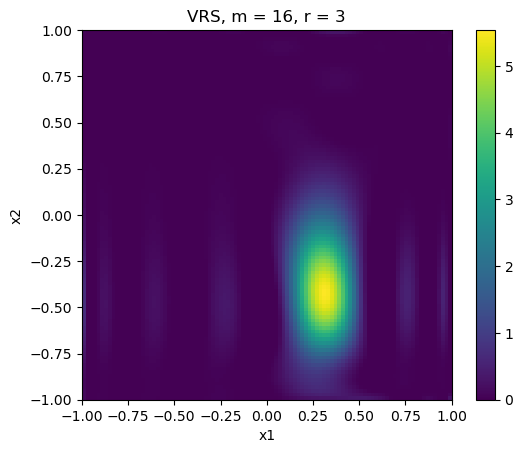

In [201]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 16, r = 3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

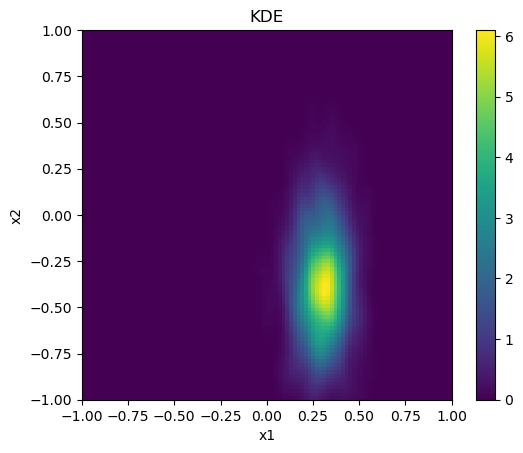

In [189]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

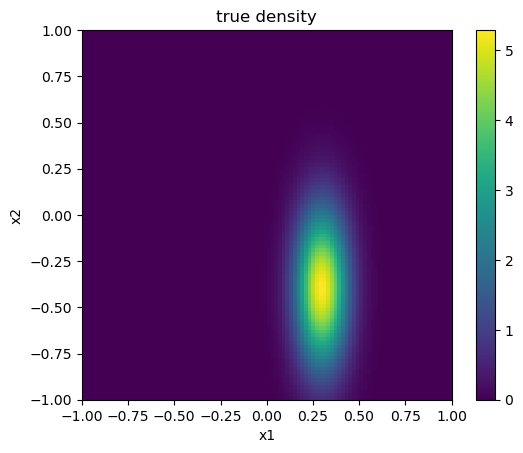

In [190]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true density')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

In [191]:
dx = x[1] - x[0]
dy = y[1] - y[0]

tot_density_vrs = density_vrs.sum() * dx * dy
tot_density_kde = density_kde.sum() * dx * dy

print("Total VRS density: ", tot_density_vrs)
print("Total KDE density: ", tot_density_kde)

Total VRS density:  1.289406657378964
Total KDE density:  0.9941616345365288


## d-dimensional Gaussian

In [368]:
d = 4

mean = 0.5
std = 0.1
data = np.vstack([generate_gaussian(1000, mean, std) for i in range(d)]).T

In [369]:
# Getting the densities using VRS
r_list = [3]*d   # truncation level (range dimension)
m_list = [5]*d   # basis size per dimension

# Run algorithm 3
C_e, basis = algorithm_3(data, r_list, m_list)

In [370]:
# Getting the densities using KDE
kde = gaussian_kde(data.T)

In [371]:
# two coordinates we want to visualize
slice1, slice2 = 2, 3

fixed_val = 0.0
grid_size = 100

In [372]:
# prepare 2D grid for axes (slice1, slice2)
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points_sliced = np.vstack([X.ravel(), Y.ravel()]).T   # (grid_size**2, 2)

# Embed into d-dimensions by fixing all other coords
full_points = np.full((grid_size*grid_size, d), fixed_val)
full_points[:, slice1] = grid_points_sliced[:, 0]
full_points[:, slice2] = grid_points_sliced[:, 1]

In [373]:
# evaluating VRS on these points

density_vrs = np.array([
    eval_density(C_e, basis, z) 
    for z in full_points
])
density_vrs = density_vrs.reshape(grid_size, grid_size)

# Set any negative values to 0, ad hoc, should fix
density_vrs[density_vrs < 0] = 0

In [374]:
# evaluating kde on these points

kde = gaussian_kde(data.T)
density_kde = kde(full_points.T).reshape(grid_size, grid_size)

In [375]:
# getting the true density

_, _, true_density = d_dim_gaussian_density([mean]*d,[std]*d, grid_size = grid_size, i = 2, j = 3)

In [376]:
# these figures below have mean -0.2, standard deviation 0.7, N = 5000

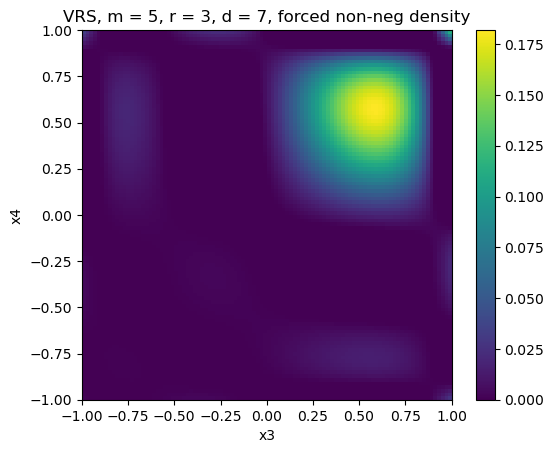

In [377]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 5, r = 3, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 8, r = 3, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 10, r = 4, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

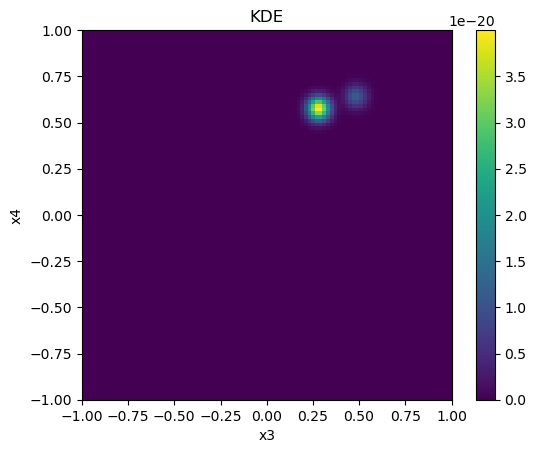

In [45]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

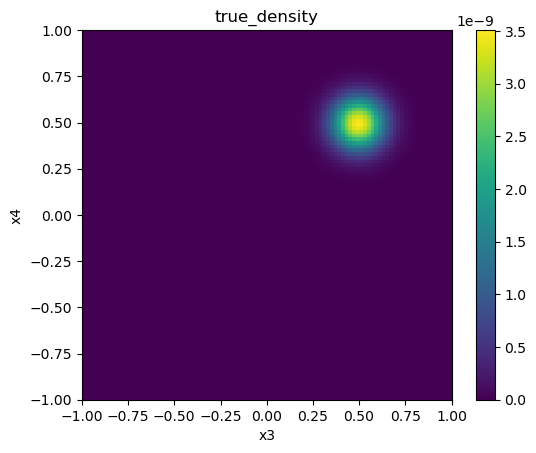

In [46]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true_density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
# everything below has mean 0.5, standard deviation 0.1, N = 1000

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 10, r = 5, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 8, r = 3, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 10, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
# above plot allowing for negative values
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 10, d = 4')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 20, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true_density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [48]:
# This bit below is trying to calculate the L2 error. I haven't really been able to get it working
# or maybe it does work and there is a bug else where
# either way just ignore everything below for now

pts = rng.normal(mean, std, size=(N, d))

f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])
f_kde = lambda pts: kde(pts.T)

In [49]:
def f_true(pts, mean, std):
    # unnormalized Gaussian
    vals = np.exp(-0.5 * np.sum(((pts - mean)/std)**2, axis=1))
    # compute normalization constant Z by Monte Carlo once
    MC = rng.uniform(-1,1,(200000, len(mean)))
    vals = np.exp(-0.5 * np.sum(((MC - mean)/std)**2, axis=1))
    const = np.mean(vals) * (2**len(mean))
    
    return vals / const

In [50]:
true = true_gaussian_density([0]*4,[0.3]*4)

NameError: name 'true_gaussian_density' is not defined

In [ ]:
M = 50000
pts_mc = rng.uniform(-1,1,(M, d))
domain_vol = 2**d


# compute relative L2 errors
err_vrs = relative_L2_error(f_vrs, true, pts_mc, domain_vol)
err_kde = relative_L2_error(f_kde, true, pts_mc, domain_vol)

## Ginzburg-Landau

### Setting it up

In [150]:
def ginzburg_landau_density(x, h, beta = 1/8, lambd = 0.02):
    d = len(x) - 2  # x0 and xd+1 are fixed at 0
    term1 = -beta * np.sum((lambd / (2 * h**2)) * (x[:-1] - x[1:])**2)
    term2 = -beta * np.sum((1 / (4 * lambd)) * (x[1:-1]**2 - 1)**2)
    return np.exp(term1 + term2)

In [151]:
def metropolis_hastings(d, n_samples, proposal_std, seed=None, beta = 1/8, lambd = 0.02):
    rng = np.random.default_rng(seed)
    h = 1/(d+1)
    x0 = 0
    xd_plus_1 = 0
    x = np.zeros(d + 2)  # Include x0 and xd+1
    samples = []

    for _ in range(n_samples):
        x_proposal = x + np.random.normal(0, proposal_std, size=x.shape)
        x_proposal[0] = x0
        x_proposal[-1] = xd_plus_1

        acceptance_ratio = (
            ginzburg_landau_density(x_proposal, h, beta, lambd)
            / ginzburg_landau_density(x, h, beta, lambd)
        )

        if np.random.rand() < acceptance_ratio:
            x = x_proposal

        samples.append(x[1:-1])  # Exclude x0 and xd+1 from the samples

    return np.array(samples)

In [152]:
def compute_normalization(d, L=2.5, n_mc=200_000):
    rng = np.random.default_rng(1234)
    U = rng.uniform(-L, L, size=(n_mc, d))  # shape (n_mc, d)
    h = 1.0 / (d + 1)

    vals = np.empty(n_mc, dtype=float)
    for i in range(n_mc):
        x_full = np.pad(U[i], (1,1), mode='constant', constant_values=0)
        vals[i] = ginzburg_landau_density(x_full, h, beta=1/8, lambd=0.02)

    return np.mean(vals) * ((2*L) ** d)

In [153]:
def f_true_gl(pts, Z_est, L=2.5, beta=1/8, lambd=0.02):
    M, d = pts.shape
    out = np.empty(M, dtype=float)
    h = 1.0 / (d + 1)

    for i in range(M):
        u = pts[i]              # in [-1,1]^d
        x = L * u               # in [-L,L]^d
        # pad with zeros at indices 0 and d+1:
        x_full = np.pad(x, (1,1), mode='constant', constant_values=0)
        raw = ginzburg_landau_density(x_full, h, beta=beta, lambd=lambd)
        out[i] = (L**d) * raw / Z_est

    return out

### Results

In [156]:
dim          = 5
N            = 100000
proposal_std = .1
L            = 2.5

In [157]:
# 1) Estimate normalization constant in original domain
Z_est = compute_normalization(dim, L=L)

# 2) Draw MH samples in original scale
data_orig = metropolis_hastings(dim, N, proposal_std, seed = 10)

# 3) Rescale interior samples to [-1,1]^d for Legendre basis
data = data_orig / L

In [ ]:
# Fit VRS on scaled data
r_list = [2] * dim
m_list = [20] * dim
C_e, basis = algorithm_3(data, r_list, m_list)
f_vrs = lambda pts: np.maximum(0,np.array([eval_density(C_e, basis, z) for z in pts]))

In [ ]:
# Fit KDE on scaled data

kde = gaussian_kde(data.T, bw_method='scott')
f_kde = lambda pts: kde(pts.T)

In [ ]:
slice1, slice2 = 1, 3
G = 100
coords = np.linspace(-1, 1, G)
X, Y = np.meshgrid(coords, coords)
grid2 = np.vstack([X.ravel(), Y.ravel()]).T

In [ ]:
full_scaled = np.zeros((G*G, dim))
full_scaled[:, slice1] = grid2[:, 0]
full_scaled[:, slice2] = grid2[:, 1]

In [ ]:
# Evaluate scaled estimates
dv = f_vrs(full_scaled).reshape(G, G)

dk = f_kde(full_scaled).reshape(G, G)

In [ ]:
h = 1 / (dim + 1)
# f_true = lambda pts: np.array([ginzburg_landau_density(pt, h) for pt in pts])
f_true = lambda pt: f_true_gl(pt, Z_est)

dtrue = f_true(full_scaled).reshape(G, G)

In [ ]:
# Plot on scaled axes
extent = [-1, 1, -1, 1]
plt.figure(); 
plt.imshow(dv, extent=extent, origin='lower')
plt.title(f'VRS Estimate (dims {slice1+1} & {slice2+1}), N = {N}, d ={dim}, r= {r_list[0]}, m = {m_list[0]}');
plt.colorbar()

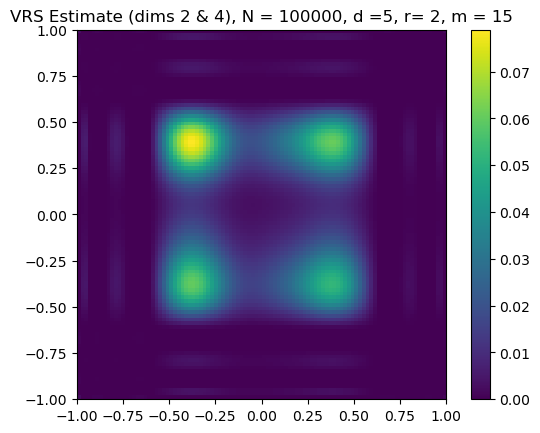

In [165]:
# Plot on scaled axes
extent = [-1, 1, -1, 1]
plt.figure(); 
plt.imshow(dv, extent=extent, origin='lower')
plt.title(f'VRS Estimate (dims {slice1+1} & {slice2+1}), N = {N}, d ={dim}, r= {r_list[0]}, m = {m_list[0]}');
plt.colorbar()

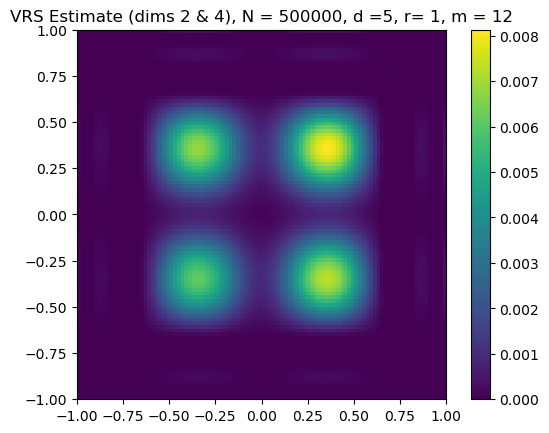

In [91]:
# Plot on scaled axes
extent = [-1, 1, -1, 1]
plt.figure(); 
plt.imshow(dv, extent=extent, origin='lower')
plt.title(f'VRS Estimate (dims {slice1+1} & {slice2+1}), N = {N}, d ={dim}, r= {r_list[0]}, m = {m_list[0]}');
plt.colorbar()

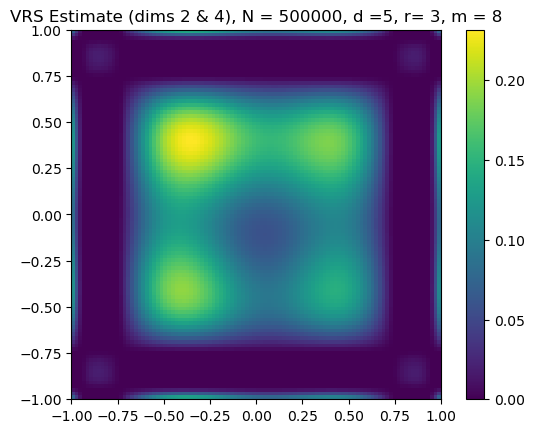

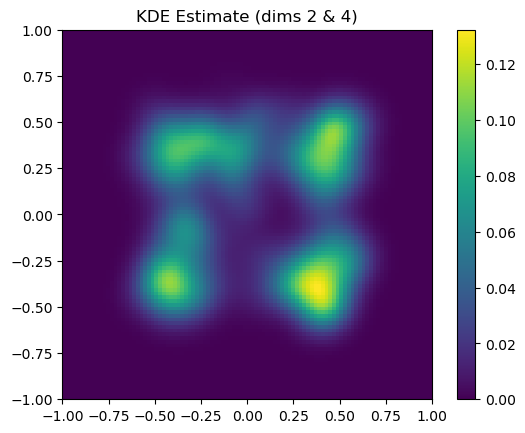

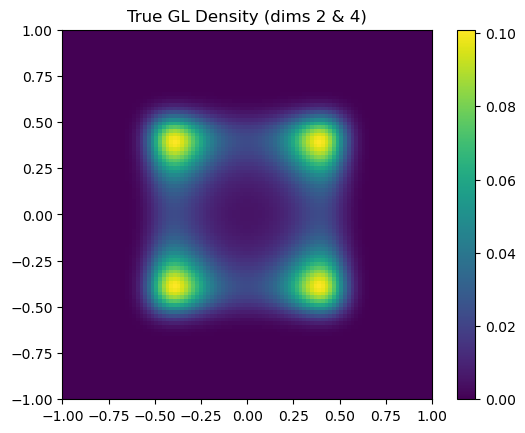

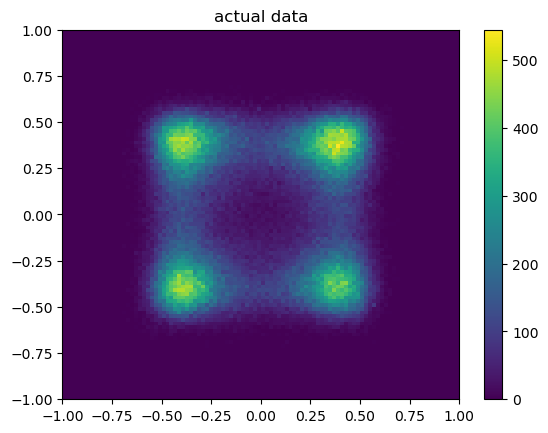

In [56]:
# Plot on scaled axes
extent = [-1, 1, -1, 1]
plt.figure(); 
plt.imshow(dv, extent=extent, origin='lower')
plt.title(f'VRS Estimate (dims {slice1+1} & {slice2+1}), N = {N}, d ={dim}, r= {r_list[0]}, m = {m_list[0]}');
plt.colorbar()

plt.figure(); 
plt.imshow(dk, extent=extent, origin='lower')
plt.title(f'KDE Estimate (dims {slice1+1} & {slice2+1})'); 
plt.colorbar()

plt.figure(); 
plt.imshow(dtrue, extent=extent, origin='lower')
plt.title(f'True GL Density (dims {slice1+1} & {slice2+1})');
plt.colorbar()

plt.figure()
plt.title('actual data')
plt.hist2d(data[:,slice1],data[:,slice2],bins = 100, range = [[-1,1],[-1,1]]);
plt.colorbar()
plt.show()

In [125]:
vals_true = f_true_gl(pts_mc, Z_est)
integral_true = domain_vol * np.mean(vals_true)
print(f"Integral of true scaled GL density over [-1,1]^{dim}: {integral_true:.6f}")

Integral of true scaled GL density over [-1,1]^5: 1.348301


In [144]:
M = 20000
rng = default_rng(10)
pts_mc = rng.uniform(-1,1,(M, dim))
domain_vol = 2**dim
f_true = lambda pt: f_true_gl(pt, Z_est)

# compute relative L2 errors
err_vrs = relative_L2_error(f_vrs, f_true, pts_mc, domain_vol)
err_kde = relative_L2_error(f_kde, f_true, pts_mc, domain_vol)

In [100]:
print(err_vrs)
print(err_kde)

0.3856302159159089
0.467209592101012


## Checking relative L2 error

### Gaussian

In [24]:
def true_gaussian_density(mean, std):
    """Return a function f_true(pts) for pts (M,d)."""
    rng = default_rng()
    def f_true(pts):
        # unnormalized Gaussian
        vals = np.exp(-0.5 * np.sum(((pts - mean)/std)**2, axis=1))
        # compute normalization constant Z by Monte Carlo once
        return vals / const
    # estimate normalization constant Z = ∫_{[-1,1]^d} e^{-...} dx
    # via a quick MC
    MC = rng.uniform(-1,1,(200000, len(mean)))
    vals = np.exp(-0.5 * np.sum(((MC - mean)/std)**2, axis=1))
    const = np.mean(vals) * (2**len(mean))
    return f_true

In [147]:
results = []
for d in [2, 3, 4, 5, 6, 7]:
    N = 100000
    mean = [0.5]*d
    std  = 0.3 * np.ones(d)
    # generate truncated Gaussian in d dims
    data = []
    rng = default_rng(10)
    while len(data) < N:
        pts = rng.normal(mean, std, size=(N, d))
        mask = np.all((pts >= -1) & (pts <= 1), axis=1)
        data.extend(pts[mask])
    data = np.array(data[:N])

    # Fit VRS
    r_list = [1]*d
    m_list = [10]*d
        
    C_e, basis = algorithm_3(data, r_list, m_list)

    # Build estimators
    f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])
    kde   = gaussian_kde(data.T, bw_method='scott')
    f_kde = lambda pts: kde(pts.T)

    # Monte Carlo points for error
    M = 50000
    pts_mc = rng.uniform(-1,1,(M, d))
    domain_vol = 2**d

    # True density
    f_true = true_gaussian_density(mean, std)

    # compute relative L2 errors
    err_vrs = relative_L2_error(f_vrs, f_true, pts_mc, domain_vol)
    err_kde = relative_L2_error(f_kde, f_true, pts_mc, domain_vol)

    results.append((d, err_vrs, err_kde))
    print(f"{d}: VRS = {err_vrs:.4f}, KDE = {err_kde:.4f}")

2: VRS = 0.0151, KDE = 0.0395
3: VRS = 0.0157, KDE = 0.0588
4: VRS = 0.0206, KDE = 0.0929
5: VRS = 0.0480, KDE = 0.1093
6: VRS = 0.0307, KDE = 0.1939


KeyboardInterrupt: 

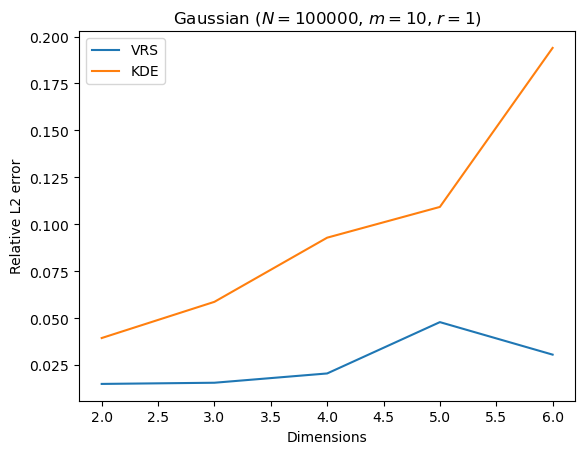

In [149]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title(f'Gaussian ($N={N}$, $m={m_list[0]}$, $r={r_list[0]}$)')
plt.legend();

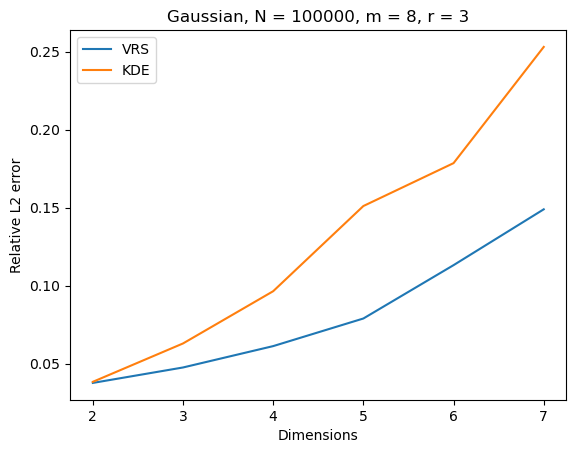

In [28]:
err_vrs = [0.0377, 0.0476, 0.0613, 0.0790, 0.1132, 0.1490]
err_kde = [0.0384, 0.0630, 0.0965, 0.1511, 0.1786, 0.2531]

plt.plot(dims, err_vrs, label = 'VRS')
plt.plot(dims, err_kde, label = 'KDE')
# plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
# plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title('Gaussian, N = 100000, m = 8, r = 3')
plt.legend();

### Uniform

In [18]:
def true_uniform_density(domain_dim):
    const = 1 / (2**domain_dim)
    return lambda pts: np.full((pts.shape[0],), const)

def generate_uniform_data(N, d, rng):
    return rng.uniform(-1, 1, size=(N, d))

rng = default_rng(123)
results = []

for d in [2, 3, 4, 5, 6]:
    N = 1000
    data = generate_uniform_data(N, d, rng)

    r_list = [2]*d
    m_list = [5]*d
    C_e, basis = algorithm_3(data, r_list, m_list)

    f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])

    kde = gaussian_kde(data.T, bw_method='scott')
    f_kde = lambda pts: kde(pts.T)

    M = 50000
    pts_mc = rng.uniform(-1, 1, size=(M, d))
    domain_vol = 2**d

    f_true = true_uniform_density(d)

    err_vrs = relative_L2_error(f_vrs, f_true, pts_mc, domain_vol)
    err_kde = relative_L2_error(f_kde, f_true, pts_mc, domain_vol)

    results.append((d, err_vrs, err_kde))
    print(f"{d}: VRS = {err_vrs:.4f}, KDE = {err_kde:.4f}")

2: VRS = 0.1355, KDE = 0.2427
3: VRS = 0.2430, KDE = 0.3237
4: VRS = 0.2111, KDE = 0.4244
5: VRS = 0.2912, KDE = 0.5047
6: VRS = 0.5294, KDE = 0.5920


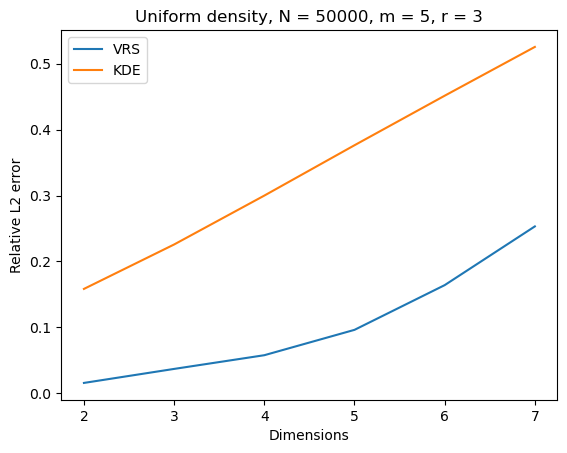

In [227]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title('Uniform density, N = 50000, m = 5, r = 3')
plt.legend();

### Ginsburg-Landau

In [155]:
dims = [2, 3, 4, 5, 6, 7]
N = 100000
proposal_std = 0.1
L = 2.5
norm_mc = 200000     # Monte Carlo points for Z_est
M_mc_error = 50000      # MC points for L2‐error
beta = 1/8
lambd = 0.02
rng_global = default_rng(123)
results = []

for d in dims:
    Z_est = compute_normalization(d, L=L, n_mc=norm_mc)

    data_orig = metropolis_hastings(d, N, proposal_std, seed = 10+d)

    # 3) Rescale interior samples to [-1,1]^d for Legendre basis
    data = data_orig / L

    r_list = [1] * d
    m_list = [20] * d
    C_e, basis = algorithm_3(data, r_list, m_list)
    f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])

    kde = gaussian_kde(data.T, bw_method="scott")
    f_kde = lambda pts: kde(pts.T)

    pts_mc = rng_global.uniform(-1, 1, size=(M_mc_error, d))
    domain_vol = 2**d

    f_true = lambda pts: f_true_gl(pts, Z_est, L=L, beta=beta, lambd=lambd)

    err_vrs = relative_L2_error(f_vrs, f_true, pts_mc, domain_vol)
    err_kde = relative_L2_error(f_kde, f_true, pts_mc, domain_vol)

    print(f"  d={d}: err_VRS = {err_vrs:.4f}, err_KDE = {err_kde:.4f}")
    results.append((d, err_vrs, err_kde))

  d=2: err_VRS = 0.2478, err_KDE = 0.1098
  d=3: err_VRS = 0.3006, err_KDE = 0.1975


KeyboardInterrupt: 

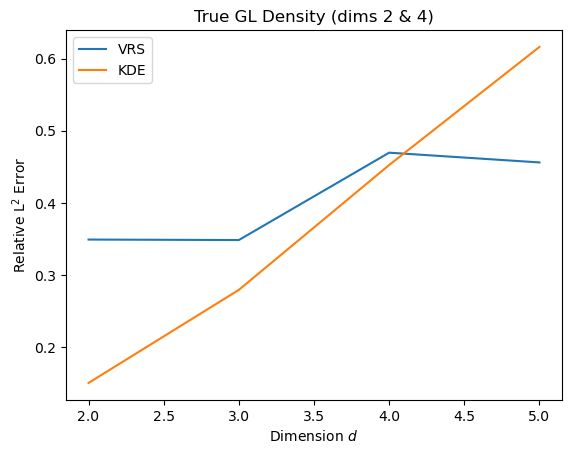

In [113]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label='VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label='KDE')
plt.xlabel('Dimension $d$')
plt.ylabel('Relative $\mathrm{L}^2$ Error')
plt.title(f'Ginzburg–Landau ($N={N}$, $m={m_list[0]}$, $r={r_list[0]}$)')
plt.legend()